In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, LSTM, Flatten
from keras.optimizers import SGD, Adam, RMSprop

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [9]:
import signal_m as s
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.loss = []
        self.val_loss = []
        self.logs = []
        
        self.fig = plt.figure()

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.loss, label="loss")
        plt.plot(self.x, self.val_loss, label="val_loss")
        plt.legend()
        plt.show();

In [10]:
import numpy as np
plot_losses = PlotLosses()

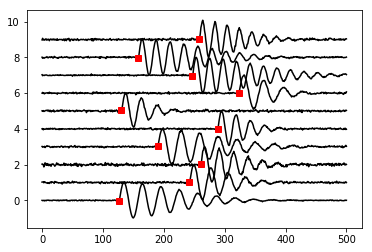

In [11]:
#ns, nr = 128, 1024
ns, nr = 501, 12
batch_size = 32
epochs = 50
learning_rate = 1e-1
nu = ns
x, y = s.generate_data_set(nr, ns, n_min=.01, n_max=.05, f_min=.06, f_max=.1, g_min=50, g_max=1000)
x_test, y_test = s.generate_data_set(256, ns, n_min=.03, n_max=.08, f_min=.06, f_max=.1, g_min=50, g_max=1000)
s.plot_sdata_jy(x, true=y)

In [15]:
y

array([[127.02659393],
       [242.42697632],
       [261.33873813],
       [190.30960965],
       [289.13459748],
       [130.69390669],
       [323.41121638],
       [247.60884633],
       [158.69136786],
       [258.84105372],
       [154.55022568],
       [375.64594159]])

In [13]:
len(x)

12

## ANN
Рассмотрим использование простой полносвязной сети, без каких-либо дополнительных слоев типа пулинга или дропаута 

In [6]:
modela = Sequential()
modela.add(Dense(nu, activation='relu', input_dim=ns))
modela.add(Dense(ns, activation='softmax')) #'sigmoid'))
modela.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(), #SGD(lr=learning_rate),
              metrics=['accuracy'])

In [59]:
nu

501

In [48]:
x.shape

(12, 501)

In [50]:
nu

501

In [57]:
y.shape

(12, 1)

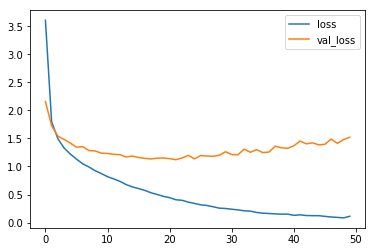

In [7]:
modela.fit(x, y,
          epochs=epochs,
          batch_size=32,
          callbacks=[plot_losses],
          validation_split=.1)

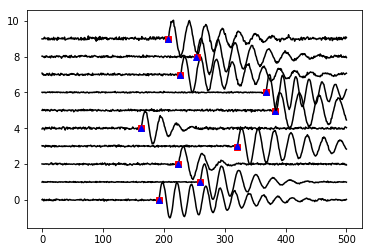

In [14]:
yp = modela.predict_classes(x_test)
s.plot_sdata_jy(x_test, true=y_test, pred=yp)

## CNN
Рассмотрим пример добавления одного сверточного слоя

In [53]:
# для сверточной сети, даже 1D, необходимо чтобы входной массив был 3D
xe = np.expand_dims(x, axis=-1)

modelb = Sequential()
modelb.add(Conv1D(filters=32, kernel_size=32,
                     padding='valid', 
                     activation='relu', 
                     input_shape=(ns, 1)))

# необходимо привести результаты применения свертки к 2D виду
modelb.add(Flatten())    
modelb.add(Dense(nu, activation='relu'))
modelb.add(Dense(ns, activation='softmax')) #'sigmoid'))
modelb.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(), #SGD(lr=learning_rate),
              metrics=['accuracy'])

In [55]:
xe.shape

(12, 501, 1)

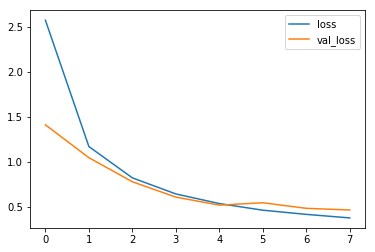

In [22]:
modelb.fit(xe, y,
          epochs=8, #epochs,
          batch_size=batch_size,
          callbacks=[plot_losses],
          validation_split=.1)

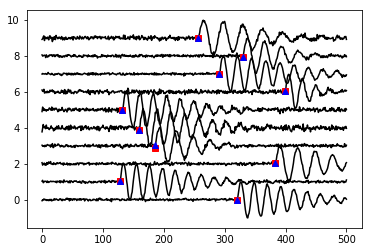

In [23]:
yp = modelb.predict_classes(np.expand_dims(x_test, axis=-1))
s.plot_sdata_jy(x_test, true=y_test, pred=yp, rand=True)

## LSTM
рассмотрим рекурентную сеть

In [11]:
def create_sequence(x, timesteps, overlap):
    nr, ns = x.shape
    z = []
    for _x in x:
        t = []
        for s in np.arange(0, ns-timesteps, overlap):
            t.append(_x[s + np.arange(timesteps)])
        z.append(np.array(t).T)
    z = np.array(z)
    return z

In [12]:
timesteps = 20
overlap = 4
xl = create_sequence(x, timesteps, overlap)

modelc = Sequential()
modelc.add(LSTM(32, return_sequences=False, 
               activation='sigmoid',
               input_shape=xl.shape[1:3]))

# необходимо привести результаты применения свертки к 2D виду
# model.add(LSTM(32))
modelc.add(Dense(ns, activation='sigmoid'))
modelc.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.001),#'rmsprop',
              metrics=['accuracy'])

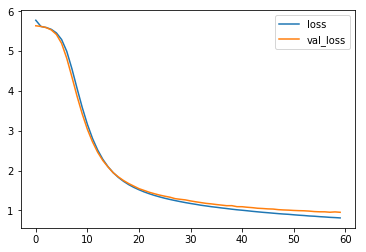

In [13]:
modelc.fit(xl, y,
          epochs=60,
          batch_size=batch_size,
          callbacks=[plot_losses],
          validation_split=.1)

In [20]:
def load_pickle(path):
    with open(path, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin'
        data = u.load()
    return data

In [21]:
import pickle
raw_data = load_pickle('3366samples.pickle')

FileNotFoundError: [Errno 2] No such file or directory: '3366samples.pickle'

In [18]:
data_x, data_y = np.array(raw_data['x']).T, raw_data['y']
x_train, x_test = data_x[:3000], data_x[3000:]
y_train, y_test = data_y[:3000], data_y[3000:]
s.plot_sdata_jy(x_train, y_train, rand=True)

NameError: name 'raw_data' is not defined

128/128 [==============================] - 0s 402us/step
[0.94366027414798737, 0.0]


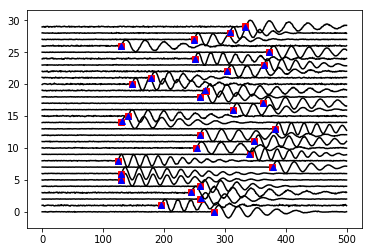

In [344]:
xl_test = create_sequence(x_test, timesteps, overlap)
yp_test = modelc.predict_classes(xl_test)
print(modelc.evaluate(xl_test, y_test))
s.plot_sdata_jy(x_test, true=y_test, pred=yp_test, nr=30, rand=True)

#### ANN real data train

In [22]:
modela.fit(data_x, data_y,
          epochs=epochs,
          batch_size=32,
          callbacks=[plot_losses],
          validation_split=.1)
yp = modelb.predict_classes(data_x)
modelb.evaluate(data_x, yp)

NameError: name 'data_x' is not defined

#### CNN real data train

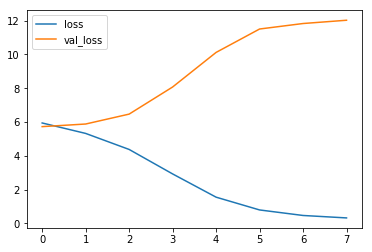

3366/3366 [==============================] - 7s 2ms/step


[0.2687107727453954, 1.0]

In [242]:
xe = np.expand_dims(data_x, axis=-1)
modelb.fit(xe, y,
          epochs=8, #epochs,
          batch_size=batch_size,
          callbacks=[plot_losses],
          validation_split=.3)
yp = modelb.predict_classes(xe)
modelb.evaluate(xe, yp)

#### RNN real data test

In [23]:
xl = create_sequence(data_x, timesteps, overlap)
#modelc.fit(xl, data_y,
#          epochs=30,
#          batch_size=batch_size,
#          callbacks=[plot_losses],
#          validation_split=.7)
yp = modelc.predict_classes(xl)
print(modelc.evaluate(xl, yp))
s.plot_sdata_jy(data_x, data_y, pred=yp, rand=True)

NameError: name 'data_x' is not defined

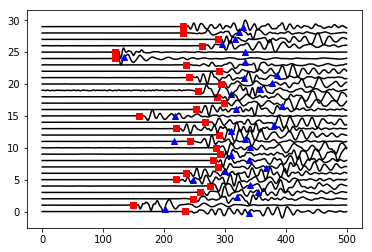

In [352]:
s.plot_sdata_jy(data_x, data_y, nr=30, pred=yp, rand=True)

#### RNN only real data train and test

In [475]:
timesteps = 10
overlap = 2
xl = create_sequence(x_train, timesteps, overlap)
model = Sequential()
model.add(LSTM(32, return_sequences=False, 
               activation='sigmoid',
               input_shape=xl.shape[1:3]))

# необходимо привести результаты применения свертки к 2D виду
# model.add(LSTM(32))
model.add(Dense(ns, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),#'rmsprop',xl = create_sequence(data_x, timesteps, overlap)
              metrics=['accuracy'])

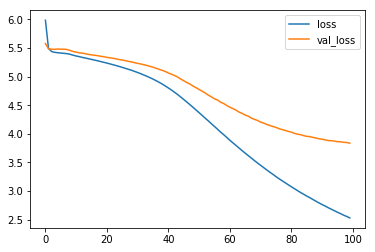

2700/2700 [==============================] - 2s 772us/step - loss: 2.5322 - acc: 0.3778 - val_loss: 3.8379 - val_acc: 0.1133


In [476]:
model.fit(xl, y_train,
          epochs=100,
          batch_size=batch_size,
          callbacks=[plot_losses, keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=-0.0, patience=10, verbose=0, mode='auto')],
          validation_split=.1)

366/366 [==============================] - 0s 300us/step
[2.1608845835826438, 1.0]


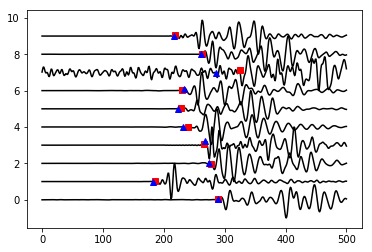

In [477]:
xl = create_sequence(x_test, timesteps, overlap)
yp = model.predict_classes(xl)
print(model.evaluate(xl, yp))
s.plot_sdata_jy(x_test, y_test, pred=yp, rand=True)

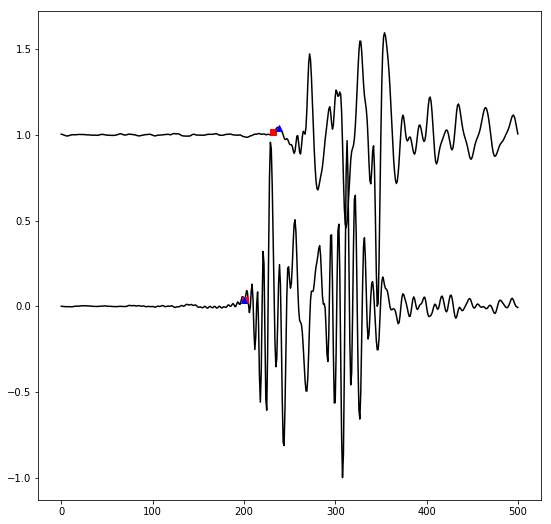

In [487]:
plt.figure(figsize=(9, 9))
s.plot_sdata_jy(x_test, true=y_test, pred=yp, nr=2, rand=True)

In [24]:
import math

accuracies = np.zeros((500,))
for k,v in enumerate(yp):
    rounded_val = round((y_test)[k]) - v
    if (rounded_val>=10):
        accuracies[10]+=1
    else:
        accuracies[round(math.fabs(rounded_val))]+=1
print(accuracies)
print("Accuracy probabilities: "+"\n")
for j in range(11):
    print("Distance "+str(j)+": "+str(accuracies[j]/366*100)+"%\n")
others = 0
for i in accuracies[j:]:
    others = others + i
print("Others: "+str(others/366*100)+"%\n")

TypeError: type numpy.ndarray doesn't define __round__ method

AttributeError: Unknown property figsize